  # Test of multiclass classifier
## (with g-r color and non-detections)

In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection, metrics, ensemble
import pickle
import itertools
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.ensemble import BalancedRandomForestClassifier as RandomForestClassifier

  ### Definition of names for plots and files

In [2]:
date = '2020609'

#names of files with detections, features and labels for the training set (v3)
#names of files with detections, features and labels for the training set (v3)
labels_file = '../alerce_trainingset/training_set_v7/dfcrossmatches_prioritized_v7.0.1.csv'

features_path = '/Users/psanchez/Documents/Postdoc/Alerce/new_DB/features/'

features_file = features_path+'features_for_ML_with_WISE.parquet'


#where the RF models are saved
model_file = 'stat_multiclassRF/rf_model_multiclass_'+date

#confusion matrixes
conf_matrix_name = 'stat_multiclassRF/confusion_matrix_rf_model_multiclass_'+date

#feature importances
feature_importance_name = 'stat_multiclassRF/feature_importance_rf_model_multiclass_'+date


### reading the training set files 


In [3]:
df_feat = pd.read_parquet(features_file)
#df_feat.set_index('oid',inplace=True)
#df_feat = pd.read_csv(features_file,index_col='oid')

df_labels = pd.read_csv(labels_file,index_col='oid')

#discarging infinite values
df_feat = df_feat.replace([np.inf, -np.inf], np.nan)

print(df_labels['class_source'].values.size)
print(df_feat.head())

173879
              MHAOV_Period_1  MHAOV_Period_2  Amplitude_1  Amplitude_2  \
oid                                                                      
ZTF17aaaaavn        0.106021        0.613572     0.078912     0.097860   
ZTF17aaaadjh        0.233443        0.233454     0.493980     0.463765   
ZTF17aaaadwo        0.060049        0.216873     0.090708     0.196542   
ZTF17aaaajjv      526.315748      555.555529     0.539600     0.566276   
ZTF17aaaakjt        0.148265        0.148265     0.564867     0.572449   

              AndersonDarling_1  AndersonDarling_2  Autocor_length_1  \
oid                                                                    
ZTF17aaaaavn           0.847902           0.673712               2.0   
ZTF17aaaadjh           1.000000           1.000000               1.0   
ZTF17aaaadwo           0.903625           0.993806               1.0   
ZTF17aaaajjv           1.000000           1.000000              14.0   
ZTF17aaaakjt           0.999907           

In [4]:
#creating new labels to combine SNII and SNIIb classes, and to add RS-CVn as a new class
df_labels['class_original'] = df_labels['classALeRCE']
df_labels.loc[(df_labels['class_source'] == 'RSCVn'), 'class_original'] = 'Periodic-Other'
df_labels.loc[(df_labels['class_original'] == 'SNIIn'), 'class_original'] = 'SNII'
df_labels.loc[(df_labels['class_original'] == 'EA'), 'class_original'] = 'E' #new name for paper
df_labels.loc[(df_labels['class_original'] == 'EB/EW'), 'class_original'] = 'E'#new name for paper
df_labels.loc[(df_labels['class_original'] == 'Ceph'), 'class_original'] = 'CEP'#new name for paper

#df_labels = df_labels[(df_labels['source']!="ASASSN") & (df_labels['source']!="GAIADR2VS")]
#df_labels = df_labels[(df_labels['source']!="ASASSN") ]

bad_oid = ['ZTF18abslpjy','ZTF18acurqaw','ZTF18aboebre','ZTF18acvvsnu','ZTF19aaydpzi','ZTF19aatevrp','ZTF18abtteyy',
          'ZTF19aatmtne','ZTF18abtfgqr','ZTF18acetlrs','ZTF18abtmgfn','ZTF18acvvppd','ZTF18aczebty','ZTF18acefhxx',
          'ZTF18acvhggp','ZTF18adbktyj','ZTF18aarcypa','ZTF18accngee','ZTF18acwvcbz','ZTF19aacypbw','ZTF18acenqto',
          'ZTF19aapfnym','ZTF18acpefgk','ZTF18aavjcpf','ZTF18aceexmi','ZTF18accnmri','ZTF18acdvvgx',
          'ZTF18accnbgw','ZTF18acemhyb','ZTF19abqrrto','ZTF19aadolpe','ZTF18abxbmqh','ZTF20aacbwbm']

df_labels.drop(bad_oid,inplace=True)

df_labels = df_labels[(df_labels['class_source']!="ELL")]

#defining the classes included in the RF model

label_order = ['SNIa', 'SNIbc', 'SNII', 'SLSN','QSO','AGN', 'Blazar', 'YSO','CV/Nova',
               'LPV', 'E', 'DSCT', 'RRL', 'CEP','Periodic-Other']

labels = df_labels.loc[df_labels.class_original.isin(label_order)][["class_original"]]

In [5]:
#defining columns excluded from the df_nd table

rm_nd_cols = [
'n_det_1',
'n_det_2',
'n_pos_1',
'n_pos_2',
'n_neg_1',
'n_neg_2',
'first_mag_1',
'first_mag_2',
'MHPS_non_zero_1',
'MHPS_non_zero_2',
'MHPS_PN_flag_1',
'MHPS_PN_flag_2',
'mean_mag_1',
'mean_mag_2',
'min_mag_1',
'min_mag_2',
'W1','W2','W3','W4',  
#'w1mpro', 'w2mpro', 'w3mpro', 'w4mpro',
#'w1mag', 'w2mag' ,'w3mag','w4mag',
'iqr_1',
'iqr_2', 
'delta_mjd_fid_1',
'delta_mjd_fid_2',
'last_mjd_before_fid_1',
'last_mjd_before_fid_2',
#'g-r_max_corr',
#'g-r_mean_corr',
#'g-r_mean',
'g-r_ml',
'MHAOV_Period_1', 'MHAOV_Period_2',
]


df = labels.join(df_feat.drop(rm_nd_cols, axis=1),how='inner')
print(df['g-r_max'].values.size)

df = df.replace([np.inf, -np.inf], np.nan)
print(df['g-r_max'].values.size)
df_train = df.copy()
df_train = df_train.fillna(-999)
labels = df[['class_original']]
df.drop(['Mean_1','Mean_2','class_original'], axis=1, inplace=True)
df = df.fillna(-999)

print(len(labels['class_original'].values))

print(df['g-r_max'].values.size)
df.head()

122531
122531
122531
122531


,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,Con_2,...,rb,sgscore1,W1-W2,W2-W3,r-W3,r-W2,g-W3,g-W2,delta_period_1,delta_period_2
oid,,,,,,,,,,,,,,,,,,,,,
ZTF19aapcxhy,0.068704,0.052665,0.665183,0.501831,1.0,1.0,0.250000,0.307692,0.0,0.0,...,0.780000,0.013542,0.796,2.889,8.106832,5.217832,8.668390,5.779390,0.202128,1.155121
ZTF18abtmwvo,0.115177,-999.000000,0.996398,-999.000000,1.0,-999.0,0.428571,-999.000000,0.0,-999.0,...,0.717857,0.216488,0.807,2.964,-999.000000,-999.000000,9.126021,6.162021,0.081005,-999.000000
ZTF18acvgdfy,0.050608,-999.000000,0.353987,-999.000000,1.0,-999.0,0.500000,-999.000000,0.0,-999.0,...,0.683333,0.088542,0.606,2.876,-999.000000,-999.000000,8.483215,5.607215,0.023222,-999.000000
ZTF19aabvjsi,-999.000000,0.028547,-999.000000,0.494246,-999.0,1.0,-999.000000,0.333333,-999.0,0.0,...,0.683333,0.035875,0.938,3.017,8.099364,5.082364,-999.000000,-999.000000,-999.000000,0.529107
ZTF18aadyxlg,-999.000000,0.021935,-999.000000,0.543918,-999.0,1.0,-999.000000,0.500000,-999.0,0.0,...,0.683333,0.161542,0.959,3.021,8.041334,5.020334,-999.000000,-999.000000,-999.000000,0.277404


  ### Defining functions to plot the confusion matrix and the feature importance


In [6]:
'''def plot_confusion_matrix(cm, classes, plot_name,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(plot_name, bbox_inches='tight')
    #plt.close()'''
    
    
def plot_confusion_matrix(cm, classes, plot_name,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = np.round((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    
    print(cm)

    fig, ax = plt.subplots(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize = 17)
    plt.yticks(tick_marks, classes, fontsize = 17)

    #fmt = '.2f' if normalize else 'd'
    fmt =  'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%d"%  (cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize = 16)

    plt.tight_layout()
    plt.ylabel('True label',fontsize = 18)
    plt.xlabel('Predicted label',fontsize = 18)
    plt.savefig(plot_name, bbox_inches='tight')
    #plt.close()
    
def plot_feature_importances(model, feature_names,feature_importances_name):
    I = np.argsort(model.feature_importances_)[::-1]
    fig, ax = plt.subplots(figsize=(16, 5), tight_layout=True)
    x_plot = np.arange(len(model.feature_importances_))
    plt.xticks(x_plot, [feature_names[i] for i in I], rotation='vertical')
    ax.bar(x_plot, height=model.feature_importances_[I]);
    plt.savefig(feature_importances_name)
    #plt.close()

### Pre-processing training data

In [7]:
Y_training = labels['class_original']#.values

X_training = df#.columns.values.tolist()

#splitting training set
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_training,
                                Y_training, test_size=0.3, stratify=Y_training)


 ## Balanced random forest

In [8]:
#Training the RF model
rf_model = RandomForestClassifier(n_estimators=500,
        max_features='auto',
        max_depth=None,
        n_jobs=8,
        class_weight='balanced_subsample',
        criterion='entropy',
        min_samples_split=2,
        min_samples_leaf=1)

rf_model.fit(X_train, y_train)

#testing model performance

y_true, y_pred = y_test, rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)

print("Accuracy:", metrics.accuracy_score(y_true, y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_true, y_pred))

#Dumping trained model

features_list = list(X_training)

with open(model_file, 'wb') as pickle_file:
        model_dump = {
            'rf_model': rf_model,
            'features': features_list,
            }
        pickle.dump(model_dump, pickle_file)

Accuracy: 0.7408596300326442
Balanced accuracy: 0.6777011783344675


In [9]:
print("Accuracy:", "%0.2f" % metrics.accuracy_score(y_true, y_pred))
print("Balanced accuracy:","%0.2f" %  metrics.balanced_accuracy_score(y_true, y_pred))

print("macro precision: ","%0.2f" %  metrics.precision_score(y_true, y_pred, average='macro'))
print("macro recall: ","%0.2f" %  metrics.recall_score(y_true, y_pred, average='macro'))
print("macro F1: ","%0.2f" %  metrics.f1_score(y_true, y_pred, average='macro'))

Accuracy: 0.74
Balanced accuracy: 0.68
macro precision:  0.49
macro recall:  0.68
macro F1:  0.50


[[ 263   85   17    5    0    9    0    0    0    0    0    0    0    1
     2]
 [  11    8    3    3    0    2    0    1    0    0    0    0    0    0
     0]
 [  14   21   50   10    0    1    0    0    0    0    0    0    0    0
     2]
 [   2    0    0    5    0    0    0    0    0    0    0    0    0    0
     0]
 [   0    1    0    3 6732  572  446   54    3    1    6    3    2    1
    27]
 [   0    0    0    0  226 1017  120   33    0    0    2    0    0    0
     2]
 [   1    2    0    0   79   62  214   16    3    3    0    0    0    0
     0]
 [   0    0    0    0    2   15    9  413    9   19   20    1    4   12
    18]
 [   7    7    3    0    0    0    4    3  183    2    9   16   16    2
     9]
 [   0    4    0    0    5    9    0  329    6 3782    2    0    0   48
    38]
 [   0    0    0    0   17    1   11  277  254    2 7348 1017  349  568
  1527]
 [   0    0    0    0    0    0    0    1    1    0   10  170   10    6
    22]
 [   0    0    1    1   16    0    8  12

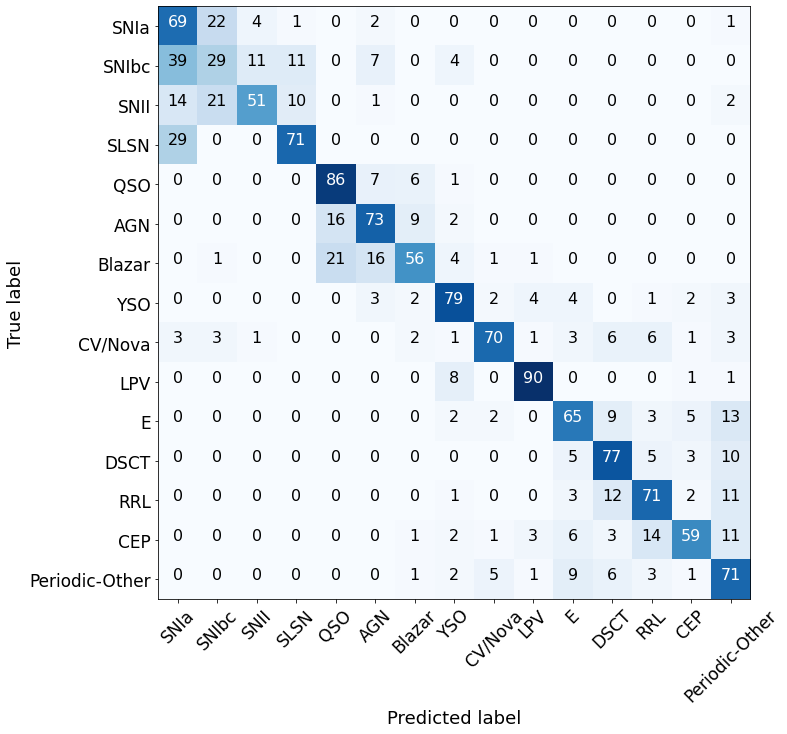

In [10]:
#plotting confusion matrix
cnf_matrix = metrics.confusion_matrix(y_true, y_pred, labels=label_order)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,label_order,'../../paper_late_classifier/paper_plots_2nd_version/conf_matrix_RF_nohierarchical_multiclass.pdf')

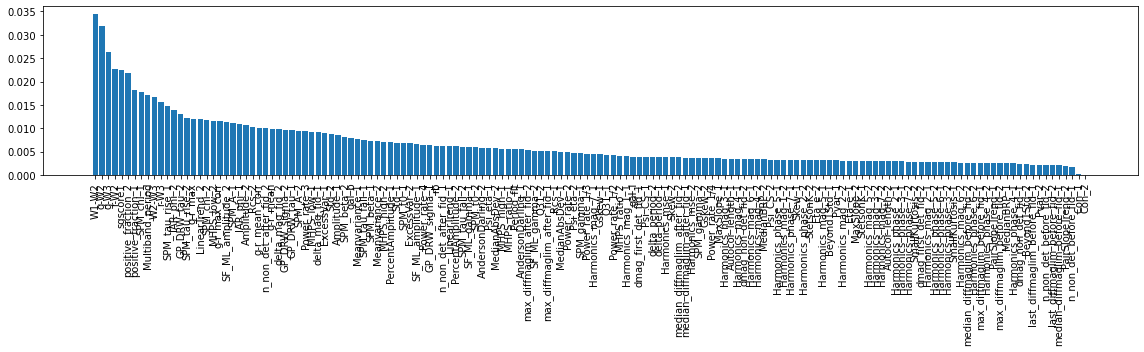

In [11]:
#plotting feature importance
plot_feature_importances(rf_model, features_list, feature_importance_name)

In [12]:
# Kaggle score

label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(Y_training)
num_y_test = label_encoder.transform(y_test)

CLASSES_REDUCED_V2 = label_encoder.inverse_transform(np.arange(len(label_order)))

def kaggle_loss(labels, predictions, weights=None):
    np.clip(predictions, 10**-15, 1-10**-15, out=predictions)
    classes = np.unique(labels)
    if weights is None:
        weights = np.ones(len(classes), dtype=np.float64)/len(classes)
    loss_sum = 0
    labels = np.array(labels)
    for i in classes:
        p = predictions[labels == i, i]
        class_score = np.mean(np.log(p))*weights[i]
        print(CLASSES_REDUCED_V2[i], class_score)
        loss_sum += class_score
    return -loss_sum/sum(weights)



print(kaggle_loss(num_y_test,y_pred_proba))

AGN -0.0777932151854121
Blazar -0.09408656651026759
CEP -0.09169909974975812
CV/Nova -0.08982347200340753
DSCT -0.07801047563585782
E -0.09189279687978599
LPV -0.06126383821230176
Periodic-Other -0.09740488470776404
QSO -0.06467932942661633
RRL -0.08434009607590559
SLSN -0.07741699075464044
SNII -0.09843672850442145
SNIa -0.08545022973241248
SNIbc -0.10205130481413713
YSO -0.09040821048586208
1.2847572386785506
